In [1]:
import pandas as pd
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
import requests
import plotly.express as px
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import networkx as nx

pd.set_option('display.max_columns',None)
# pd.set_option('display.max_rows',None)
pd.set_option('display.float_format', lambda x: f'%.{2}f' % x)
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv('../8Jul2020-14Jul2020.csv')
df['Date'] = pd.to_datetime(df['Start Date'], dayfirst=True)
df.sort_values(by='Date', inplace=True)
df['Date'] = df['Date'].dt.date

cluster = df[['StartStation Name', 'StartStation lat', 'StartStation long']]
cluster.drop_duplicates(keep='first', inplace=True)
cluster.head()

C:\Users\rahin\AppData\Local\Temp\ipykernel_30044\61486702.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster.drop_duplicates(keep='first', inplace=True)


,StartStation Name,StartStation lat,StartStation long
0,"Jubilee Plaza, Canary Wharf",51.50,-0.02
1,"Ford Road, Old Ford",51.53,-0.03
2,"Houndsditch, Aldgate",51.51,-0.08
4,"Ossulston Street, Somers Town",51.53,-0.13
6,"Endsleigh Gardens, Euston",51.53,-0.13


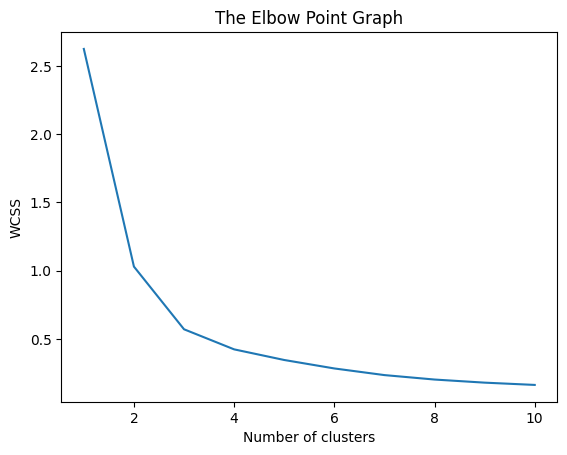

In [3]:
X = cluster[['StartStation lat', 'StartStation long']].values
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    #appending the WCSS to the list (kmeans.inertia_ returns the WCSS value for an initialized cluster)
    wcss.append(kmeans.inertia_)

#Plotting The Elbow graph
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Point Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [4]:
n_clusters_ = 750
kmeans = KMeans(n_clusters = n_clusters_, init ='k-means++')
kmeans.fit(X) # Compute k-means clustering.
labels = kmeans.fit_predict(X)

In [5]:
# Coordinates of cluster centers.
centers = kmeans.cluster_centers_ 
# print((centers))

In [6]:
# map each station with its region
cluster['clusters'] = labels
cluster.index = cluster['StartStation Name']
cluster_map = cluster['clusters'].to_dict()

df['cluster'] = df['StartStation Name'].map(cluster_map)
df.head()

C:\Users\rahin\AppData\Local\Temp\ipykernel_30044\3448031555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['clusters'] = labels


,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,EndStation lat,EndStation long,EndStation nbBikes,EndStation nbStandardBikes,EndStation nbEBikes,EndStation nbEmptyDocks,EndStation nbDocks,StartStation lat,StartStation long,StartStation nbBikes,StartStation nbStandardBikes,StartStation nbEBikes,StartStation nbEmptyDocks,StartStation nbDocks,Date,cluster
0,99188805,780,13656,08/07/2020 00:13,476,"Stebondale Street, Cubitt Town",08/07/2020 00:00,532,"Jubilee Plaza, Canary Wharf",51.49,-0.01,26,24,2,3,29,51.50,-0.02,46,45,1,17,63,2020-07-08,174
1,99188806,180,4393,08/07/2020 00:03,531,"Twig Folly Bridge, Mile End",08/07/2020 00:00,517,"Ford Road, Old Ford",51.53,-0.04,6,6,0,15,21,51.53,-0.03,2,2,0,16,18,2020-07-08,558
2,99188809,960,8973,08/07/2020 00:17,508,"Fournier Street, Whitechapel",08/07/2020 00:01,779,"Houndsditch, Aldgate",51.52,-0.07,8,8,0,10,18,51.51,-0.08,3,3,0,25,28,2020-07-08,727
3,99188810,960,7141,08/07/2020 00:17,508,"Fournier Street, Whitechapel",08/07/2020 00:01,779,"Houndsditch, Aldgate",51.52,-0.07,8,8,0,10,18,51.51,-0.08,3,3,0,25,28,2020-07-08,727
4,99188807,600,15085,08/07/2020 00:11,201,"Dorset Square, Marylebone",08/07/2020 00:01,797,"Ossulston Street, Somers Town",51.52,-0.16,15,15,0,1,16,51.53,-0.13,28,27,1,2,30,2020-07-08,46


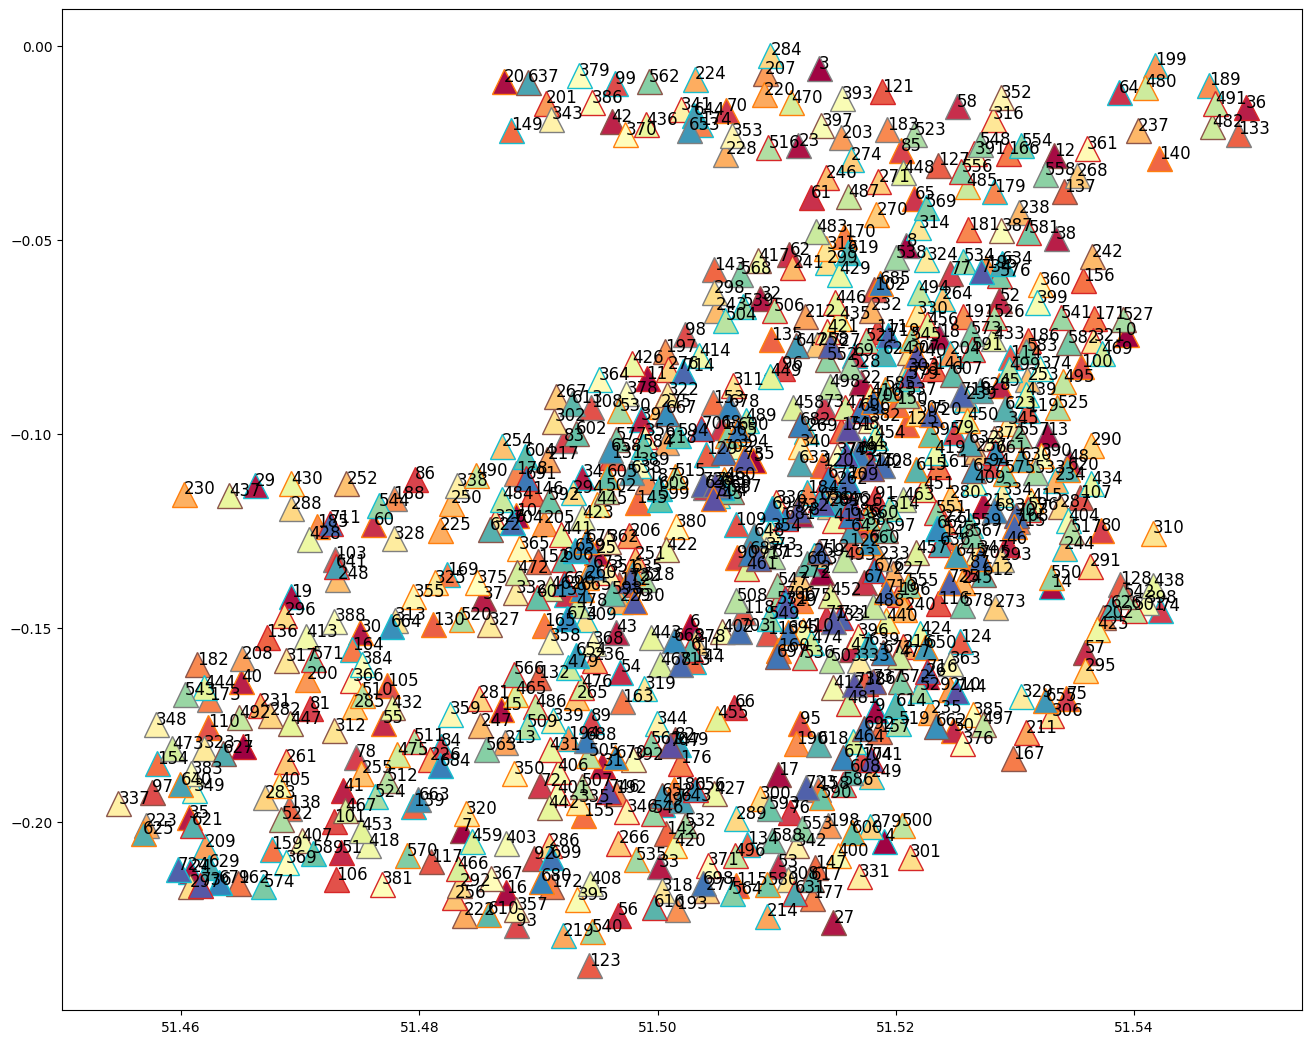

In [7]:
plt.rcParams['figure.figsize'] = [16,13]

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
# BBox = (-79.4900,-79.2700,43.6100,43.7200)
#map_tor = mpimg.imread('map.png')
fig, ax = plt.subplots()
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
#     print(tuple(col))

    xy = X[class_member_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)
    ax.plot(centers[k, 0], centers[k, 1], '^',markerfacecolor=tuple(col), markersize=18)
    ax.text(centers[k, 0], centers[k, 1], k,fontsize=12) 
# ax.set_xlim(BBox[0],BBox[1])
# ax.set_ylim(BBox[2],BBox[3])
# ax.imshow(map_tor, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

In [8]:
temp = df.groupby(['Date', 'StartStation Name', 'EndStation Name', 'StartStation lat', 'StartStation long',
                  'EndStation lat', 'EndStation long','cluster'])['Duration'].agg(['mean'])
temp.reset_index(drop=False, inplace=True)

cluster1 = temp[temp['cluster'] == 0]
cluster2 = temp[temp['cluster'] == 1]
cluster3 = temp[temp['cluster'] == 2]

temp.head()

,Date,StartStation Name,EndStation Name,StartStation lat,StartStation long,EndStation lat,EndStation long,cluster,mean
0,2020-07-08,"Abbey Orchard Street, Westminster","Abbey Orchard Street, Westminster",51.50,-0.13,51.50,-0.13,251,1720.00
1,2020-07-08,"Abbey Orchard Street, Westminster","Aldersgate Street, Barbican",51.50,-0.13,51.52,-0.10,251,1140.00
2,2020-07-08,"Abbey Orchard Street, Westminster","Beaumont Street, Marylebone",51.50,-0.13,51.52,-0.15,251,1020.00
3,2020-07-08,"Abbey Orchard Street, Westminster","Belgrove Street , King's Cross",51.50,-0.13,51.53,-0.12,251,1110.00
4,2020-07-08,"Abbey Orchard Street, Westminster","Bricklayers Arms, Borough",51.50,-0.13,51.50,-0.09,251,1140.00


In [9]:
len(cluster3)

245

In [10]:
N = 300

temp3 = cluster1['StartStation Name'].values[:N]
temp4 = cluster1[['StartStation lat', 'StartStation long']].apply(tuple, axis=1).values[:N]

temp5 = cluster1['EndStation Name'].values[:N]
temp6 = cluster1[['EndStation lat', 'EndStation long']].apply(tuple, axis=1).values[:N]

pos1 = {A: B for A, B in zip(temp3, temp4)}
pos2 = {A: B for A, B in zip(temp5, temp6)}
pos = {**pos1, **pos2}

In [11]:
# temp3 = cluster1['StartStation Name'].values
# temp4 = cluster1[['StartStation lat', 'StartStation long']].apply(tuple, axis=1).values

# pos = {A: B for A, B in zip(temp3, temp4)}

In [12]:
X = np.array(cluster1[['StartStation Name', 'EndStation Name']])[:N]
y = np.array(cluster1['mean'])[:N]

temp1 = cluster1[['StartStation Name', 'EndStation Name']].apply(tuple, axis=1).values[:N]
temp2 = cluster1['mean'].values[:N]

edge_labels = {A: B for A, B in zip(temp1, temp2)}
# edge_labels

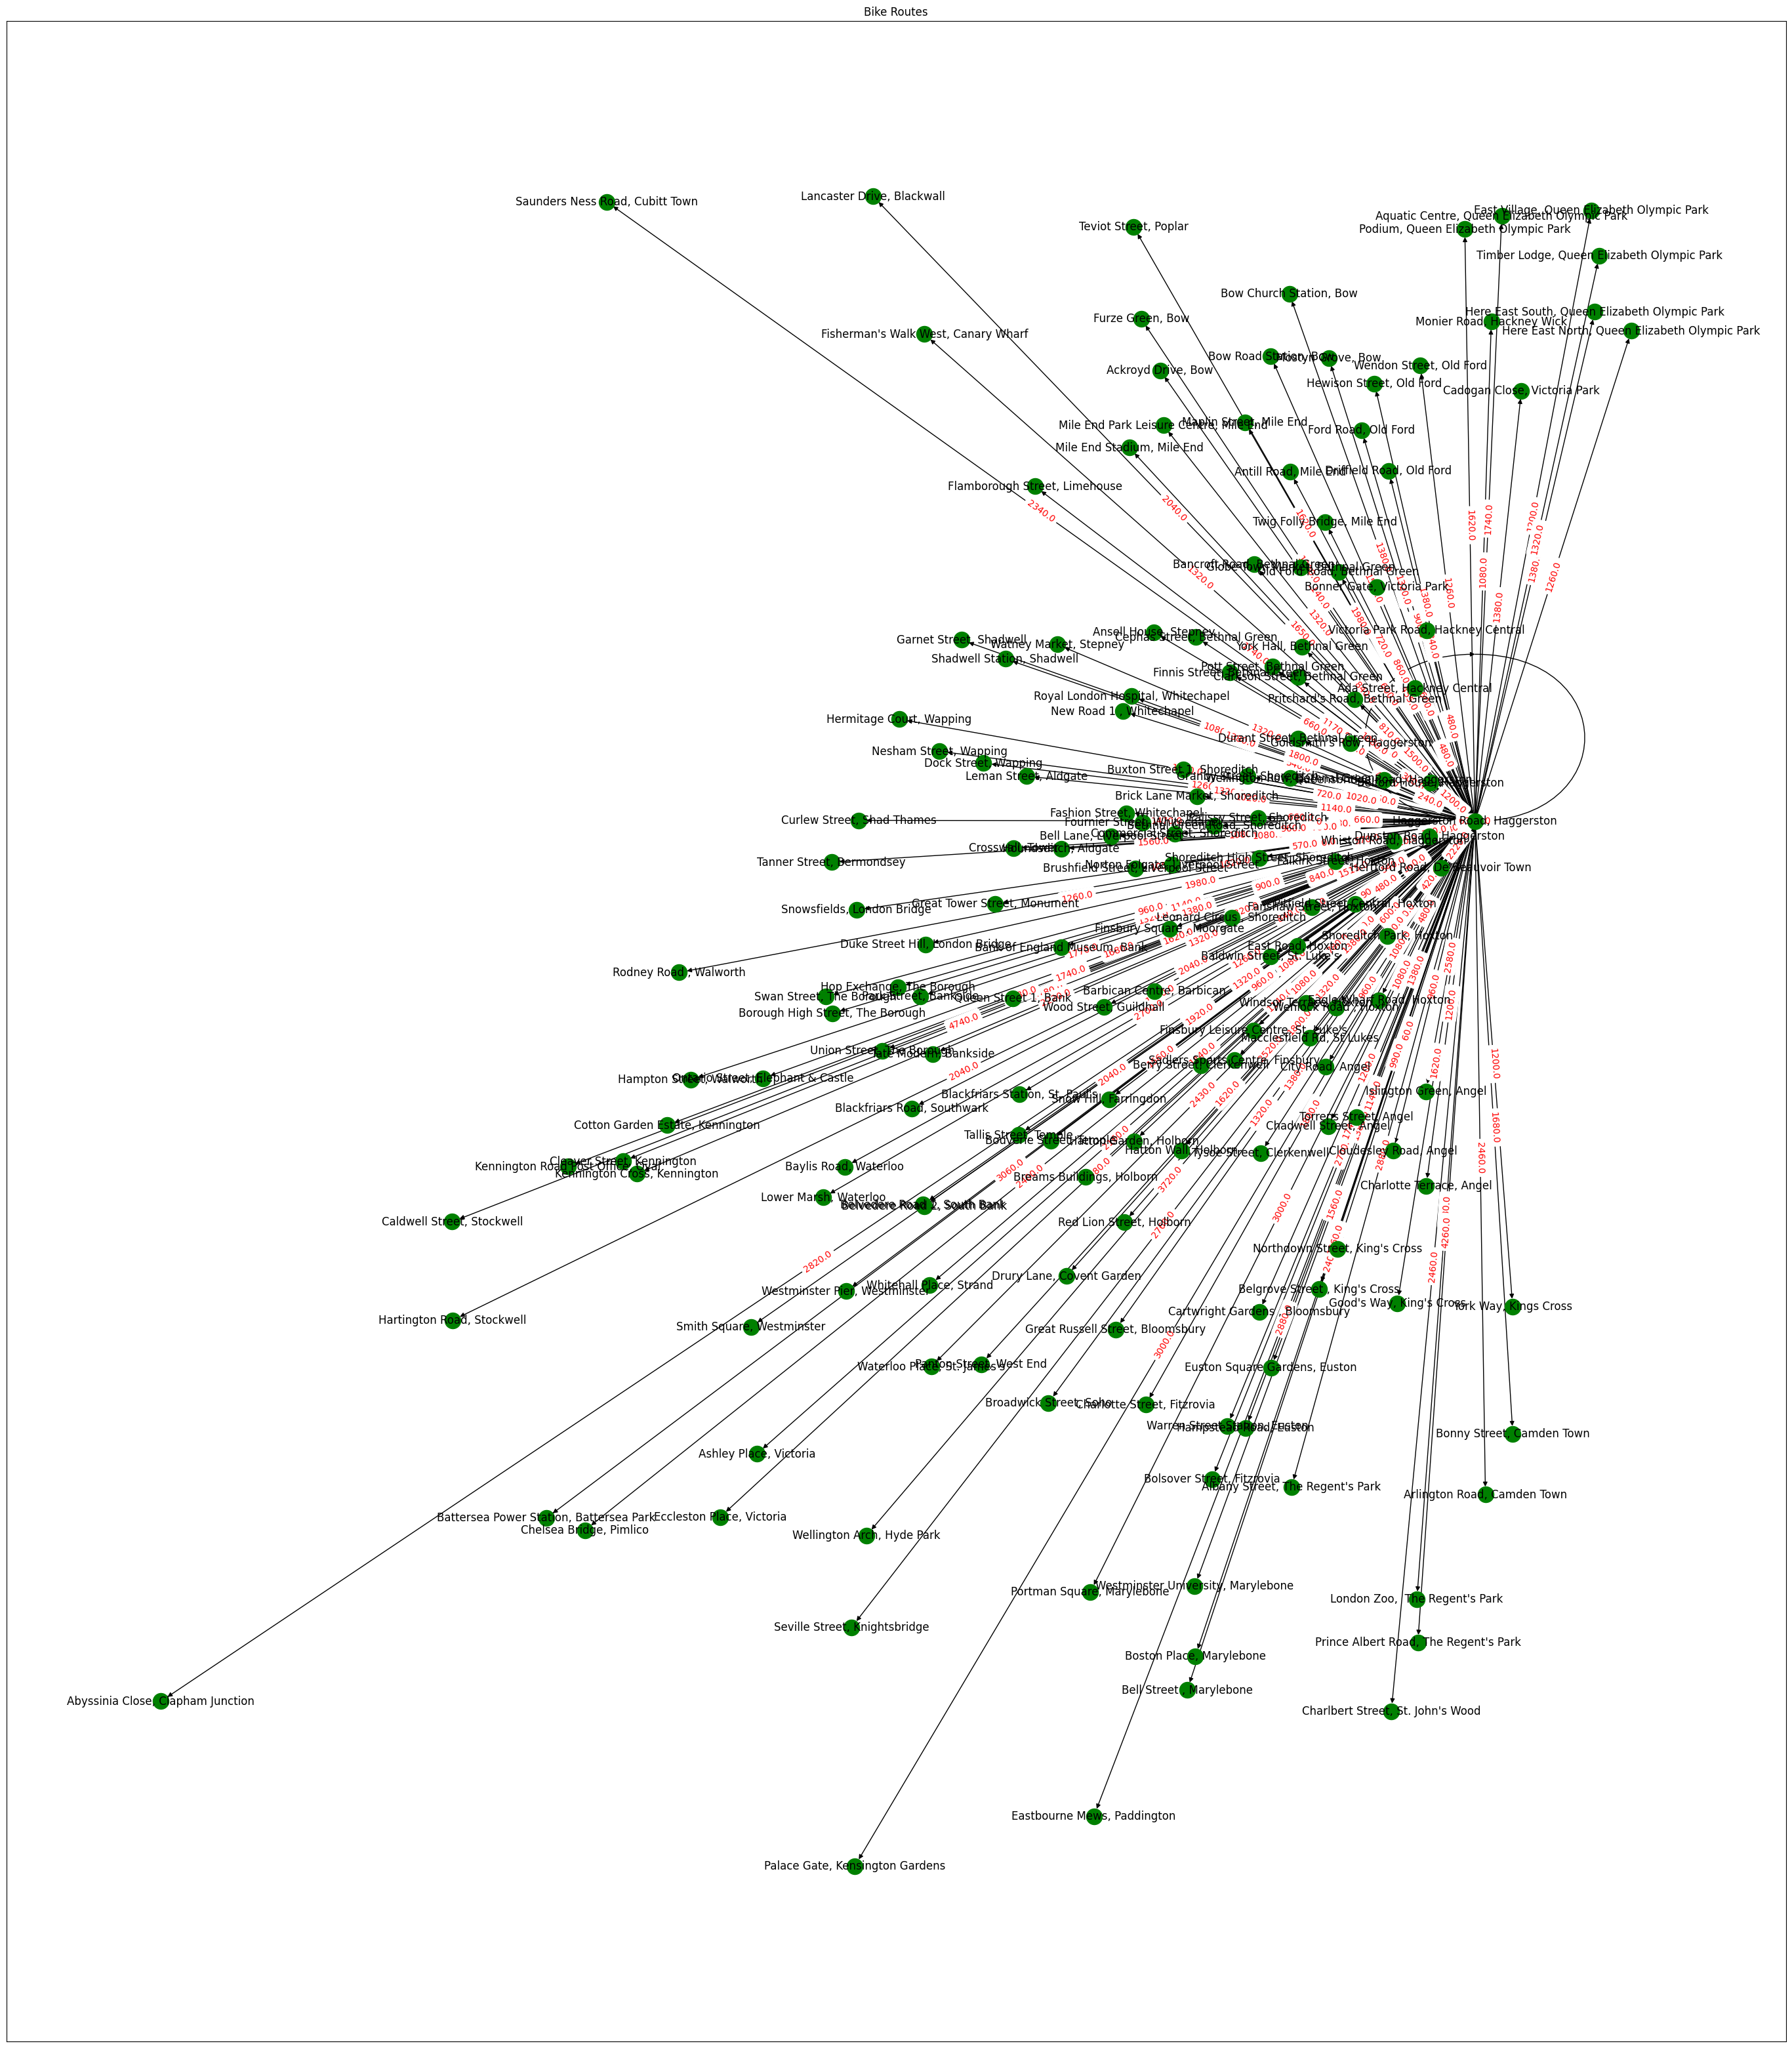

In [13]:
G = nx.DiGraph()
G.add_edges_from(X)
plt.figure(figsize =(35, 40))
nx.draw_networkx(G, pos = pos, node_color ='green')
nx.draw_networkx_edge_labels(G, pos = pos,
                             edge_labels=edge_labels,
                             font_color='red')


plt.title("Bike Routes")
plt.show()